In [47]:
import os
from scipy.fft import dct, idct
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import convolve2d
from math import sqrt
img_path='lena_grey.bmp'
N = 1024

#v = 'additive'
#alpha = 24 
v = 'multiplicative'
alpha = 0.1
np.random.seed(seed=123)

# image = cv2.imread(img_path, 0)

In [48]:
def embedding(image, mark_size, alpha, v='multiplicative'):
    # Get the DCT transform of the image
    ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')

    # Get the locations of the most perceptually significant components
    sign = np.sign(ori_dct)
    ori_dct = abs(ori_dct)
    locations = np.argsort(-ori_dct,axis=None) # - sign is used to get descending order
    rows = image.shape[0]
    locations = [(val//rows, val%rows) for val in locations] # locations as (x,y) coordinates

    # Generate a watermark
    mark = np.random.uniform(0.0, 1.0, mark_size)
    mark = np.uint8(np.rint(mark))
    np.save('mark.npy', mark)

    # Embed the watermark
    watermarked_dct = ori_dct.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations[1:], mark)):
        if v == 'additive':
            watermarked_dct[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_dct[loc] *= 1 + ( alpha * mark_val)

    # Restore sign and o back to spatial domain
    watermarked_dct *= sign
    watermarked = np.uint8(idct(idct(watermarked_dct,axis=1, norm='ortho'),axis=0, norm='ortho'))#NEED to convert to integeger, because we would be able to plot with real and complex number

    return mark, watermarked


# mark, watermarked = embedding(image, N, alpha, v)
# cv2.imwrite('watermarked.bmp', watermarked)

In [105]:
def wpsnr(img1, img2):
  img1 = np.float32(img1)/255.0
  img2 = np.float32(img2)/255.0
  difference = img1-img2
  same = not np.any(difference)
  if same is True:
      return 9999999
  csf = np.genfromtxt('csf.csv', delimiter=',')
  ew = convolve2d(difference, np.rot90(csf,2), mode='valid')
  decibels = 20.0*np.log10(1.0/sqrt(np.mean(np.mean(ew**2))))
  return decibels

# Plot the two images side by side
# plt.figure(figsize=(15, 6))
# plt.subplot(121)
# plt.title('Original')
# plt.imshow(image, cmap='gray')
# plt.subplot(122)
# plt.title('Watermarked')
# plt.imshow(watermarked,cmap='gray')
# plt.show()

# Compute quality
# psnr = cv2.PSNR(image, watermarked)
# print('PSNR: %.2fdB' % psnr)
# w = wpsnr(image, watermarked)
# print('wPSNR: %.2fdB' % w)


In [106]:
def detection(image, watermarked, alpha, mark_size, v='multiplicative'):
    ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')
    wat_dct = dct(dct(watermarked,axis=0, norm='ortho'),axis=1, norm='ortho')

    # Get the locations of the most perceptually significant components
    ori_dct = abs(ori_dct)
    wat_dct = abs(wat_dct)
    locations = np.argsort(-ori_dct,axis=None) # - sign is used to get descending order
    rows = image.shape[0]
    locations = [(val//rows, val%rows) for val in locations] # locations as (x,y) coordinates

    # Generate a watermark
    w_ex = np.zeros(mark_size, dtype=np.float64)

    # Embed the watermark
    for idx, loc in enumerate(locations[1:mark_size+1]):
        if v=='additive':
            w_ex[idx] =  (wat_dct[loc] - ori_dct[loc]) /alpha
        elif v=='multiplicative':
            w_ex[idx] =  (wat_dct[loc] - ori_dct[loc]) / (alpha*ori_dct[loc])
            
    return w_ex

# w_ex = detection(image, watermarked, alpha, N, v)

In [107]:
def similarity(X,X_star):
    #Computes the similarity measure between the original and the new watermarks.
    s = np.sum(np.multiply(X, X_star)) / (np.sqrt(np.sum(np.multiply(X, X))) * np.sqrt(np.sum(np.multiply(X_star, X_star))))
    return s

def compute_thr(sim, mark_size, w):
    SIM = np.zeros(1000)
    for i in range(1, 1000):
        r = np.random.uniform(0.0, 1.0, mark_size)
        SIM[i] = (similarity(w, r))
    
    SIM.sort()
    t = SIM[-1]
    T = t + (0.1*t)
    print('threshold: ', T)
    return T

# sim = similarity(mark, w_ex)
# T = compute_thr(sim, N, mark)

# if sim > T:
#     print('Mark has been found. SIM = %f' % sim)
# else:
#     print('Mark has been lost. SIM = %f' % sim)

## PIPELINE

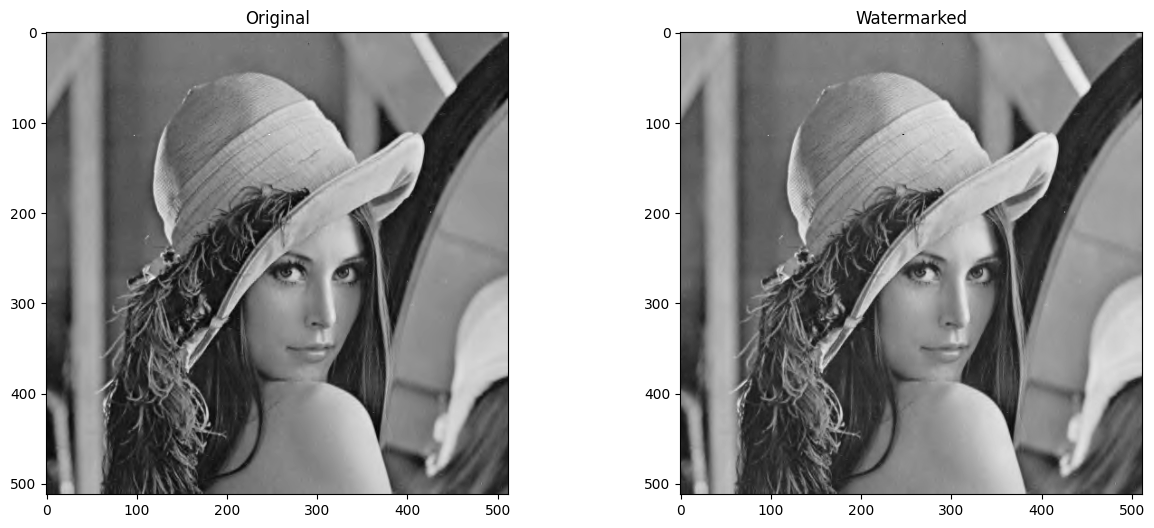

PSNR: 37.73dB
wPSNR: 43.80dB
threshold:  0.7329158312773446
Mark has been found. SIM = 0.998467


In [108]:
from attack import attack,attack_types

# load the image
image = cv2.imread(img_path, 0)

#Embed the watermark and save it
mark, watermarked = embedding(image, N, alpha, v)

#plot the original and watermarked image
cv2.imwrite('watermarked.bmp', watermarked)
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.title('Original')
plt.imshow(image, cmap='gray')
plt.subplot(122)
plt.title('Watermarked')
plt.imshow(watermarked,cmap='gray')
plt.show()

#check the quality of the watermarked image with respect to the original image
psnr = cv2.PSNR(image, watermarked)
print('PSNR: %.2fdB' % psnr)
w = wpsnr(image, watermarked)
print('wPSNR: %.2fdB' % w)


#Detect the watermark
w_ex = detection(image, watermarked, alpha, N, v)

#Compute the similarity and threshold
sim = similarity(mark, w_ex)
T = compute_thr(sim, N, mark)

if sim > T:
    print('Mark has been found. SIM = %f' % sim)
else:
    print('Mark has been lost. SIM = %f' % sim)

## Attack

In [171]:

import random
# def attack(img):
#   types = ['','awgn', 'blur', 'sharpening', 'median', 'resizing', 'jpeg_compression', 'none']
#   i = random.randint(1,7)
#   if i==1:
#     attacked = awgn(img, 3., 123)
#   elif i==2:
#     attacked = blur(img, [3, 3])
#   elif i==3:
#     attacked = sharpening(img, 1, 1)
#   elif i==4:
#     attacked = median(img, [3, 3])
#   elif i==5:
#     attacked = resizing(img, 0.8)
#   elif i==6:
#     attacked = jpeg_compression(img, 75)
#   elif i ==7:
#      attacked = img
     

#   print('Random attack: ', types[i])
#   psnr = cv2.PSNR(img, attacked)
#   print('PSNR: %.2fdB' % psnr)
#   w = wpsnr(img, attacked)
#   print('wPSNR: %.2fdB' % w)
#   return (attacked, psnr, w,type[i])


def awgn(img, std_range, seed):
  mean = 0.0   # some constant
  std = random.randint(std_range[0], std_range[1])
  #np.random.seed(seed)
  attacked = img + np.random.normal(mean, std, img.shape)
  attacked = np.clip(attacked, 0, 255)
  attacked = np.asarray(attacked,dtype=np.uint8)
  return (attacked, 'AWGN',"std: "+str(std))

def blur(img, sigma_range):
  from scipy.ndimage import gaussian_filter
  sigma = random.randint(sigma_range[0], sigma_range[1])
  attacked = gaussian_filter(img, [sigma,sigma])
  return (attacked, 'Blur', "sigma: "+str(sigma))

def sharpening(img, sigma_range, alpha_range):
  import scipy
  from scipy.ndimage import gaussian_filter
  import matplotlib.pyplot as plt
  sigma = random.randint(sigma_range[0], sigma_range[1])
  alpha = random.randint(alpha_range[0], alpha_range[1])
  #print(img/255)
  filter_blurred_f = gaussian_filter(img, sigma)

  attacked = img + alpha * (img - filter_blurred_f)
  return ( attacked, 'Sharpening', "sigma: "+str(sigma) + "alpha: "+str(alpha))

def median(img, kernel_size_w_range, kernel_size_h_range):
  from scipy.signal import medfilt
  k_w  = random.randint(0,len(kernel_size_w_range)-1)
  k_h  = random.randint(0,len(kernel_size_h_range)-1)
  kernel_size = [kernel_size_w_range[k_w], kernel_size_h_range[k_h]]
  attacked = medfilt(img, kernel_size)
  return (attacked, 'Median', "kernel_size: "+str(kernel_size))

def resizing(img, scale_range):
  from skimage.transform import rescale
  x, y = img.shape
  scale = random.uniform(scale_range[0], scale_range[1])
  attacked = rescale(img, scale)
  attacked = rescale(attacked, 1/scale)
  attacked = attacked[:x, :y]
  attacked = np.asarray(attacked,dtype=np.uint8)
  return (attacked, 'Resizing', "scale: "+str(scale))

def jpeg_compression(img, QF_range):
  from PIL import Image
  img = Image.fromarray(img)
  QF = random.randint(QF_range[0], QF_range[1])
  img.save('tmp.jpg',"JPEG", quality=QF)
  attacked = Image.open('tmp.jpg')
  attacked = np.asarray(attacked,dtype=np.uint8)
  os.remove('tmp.jpg')

  return (attacked, 'JPEG Compression', "QF: "+str(QF))

In [178]:
  
def attacks(img): 
  # List of all attack functions
  
  attack_functions = [
      lambda img: awgn(img, std_range=(1,10), seed=123),                              # AWGN attack
      lambda img: blur(img,sigma_range =(1, 5)),                                      # Blur attack
      lambda img: sharpening(img, sigma_range=(1,5), alpha_range=(1,5)),              # Sharpening attack
      lambda img: median(img, kernel_size_w_range=[3,5,7], kernel_size_h_range=[3,5,7]),  # Median attack
      lambda img: resizing(img, scale_range = (0.3,1)),                               # Resizing attack
      lambda img: jpeg_compression(img, QF_range=(1,100)),                            #JPEG compression attack
      #lambda img: (img,'None','None')                                                        # No attack (identity)
  ]
  

  max_psnr = -1
  best_attack = None
  best_wpsnr = -1
  best_attack_name = None
  best_params = ""
  history = []
  for i, attack_fn in enumerate(attack_functions):
    for j in range(3):
      (attacked,attack_name,used_params) = attack_fn(img)
      print(attack_name, used_params)
    
      psnr = cv2.PSNR(img, attacked)
    
      w = wpsnr(img, attacked) 
    
      if psnr > max_psnr:
        max_psnr = psnr
        best_wpsnr = w
        best_attack = attacked
        best_attack_name = attack_name
        best_params = used_params
      history.append((attack_name, psnr, w, used_params))
      print(f'Attack: {attack_name}, PSNR: {psnr:.2f}dB, wPSNR: {w:.2f}dB')

  print(f'Best attack: {best_attack_name}, Max PSNR: {max_psnr:.2f}dB, wPSNR: {best_wpsnr:.2f}dB, Params: {best_params}')
  return best_attack, max_psnr, best_wpsnr, best_attack_name
  

In [179]:

attacks(watermarked)
print("done")

AWGN std: 5
Attack: AWGN, PSNR: 34.11dB, wPSNR: 48.99dB
AWGN std: 4
Attack: AWGN, PSNR: 36.01dB, wPSNR: 50.71dB
AWGN std: 2
Attack: AWGN, PSNR: 41.75dB, wPSNR: 55.36dB
Blur sigma: 3
Attack: Blur, PSNR: 26.43dB, wPSNR: 32.53dB
Blur sigma: 3
Attack: Blur, PSNR: 26.43dB, wPSNR: 32.53dB
Blur sigma: 3
Attack: Blur, PSNR: 26.43dB, wPSNR: 32.53dB
Sharpening sigma: 4alpha: 5
Attack: Sharpening, PSNR: 12.00dB, wPSNR: 19.58dB
Sharpening sigma: 3alpha: 2
Attack: Sharpening, PSNR: 15.71dB, wPSNR: 23.50dB
Sharpening sigma: 5alpha: 1
Attack: Sharpening, PSNR: 17.59dB, wPSNR: 24.83dB
Median kernel_size: [7, 7]
Attack: Median, PSNR: 29.68dB, wPSNR: 37.39dB
Median kernel_size: [5, 5]
Attack: Median, PSNR: 32.22dB, wPSNR: 41.60dB
Median kernel_size: [3, 3]
Attack: Median, PSNR: 36.89dB, wPSNR: 49.59dB
Resizing scale: 0.7556514267618817
Attack: Resizing, PSNR: 5.66dB, wPSNR: 11.62dB
Resizing scale: 0.9757764699605744
Attack: Resizing, PSNR: 5.66dB, wPSNR: 11.62dB
Resizing scale: 0.45027804810089433
Attac

(array([[164, 163, 162, ..., 165, 158, 137],
        [164, 163, 163, ..., 163, 155, 130],
        [165, 164, 164, ..., 159, 154, 129],
        ...,
        [ 42,  43,  45, ...,  95,  95,  95],
        [ 42,  43,  45, ...,  94,  94,  94],
        [ 42,  43,  45, ...,  95,  94,  94]], dtype=uint8),
 51.594660067103305,
 71.21394493576994,
 'JPEG Compression')